# PIPLINE FOR STOCKS

## Setup ban đầu

In [1]:
%pip install vnstock
%pip install scipy
%pip install mplfinance

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

pd.set_option('display.width', 2000)        
pd.set_option('display.max_columns', 20) 

In [3]:
from vnstock import *
from vnstock import Vnstock
import pandas as pd
from datetime import datetime
import mplfinance as mpf
from matplotlib.dates import DateFormatter
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from typing import Tuple
from numpy.random import multivariate_normal
import matplotlib.dates as mdates
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
import re

In [4]:
def crawl_data_portfolio(list_stock, start_date, end_date, interval='1H'):
    
    all_data = []

    for symbol in list_stock:
        try:
            stock = Vnstock().stock(symbol=symbol, source='TCBS')
            df = stock.quote.history(start=start_date, end=end_date, interval=interval)
            df['symbol'] = symbol
            all_data.append(df)
        except Exception as e:
            print(f"⚠️ Lỗi khi lấy dữ liệu cho {symbol}: {e}")
            continue

    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        return pd.DataFrame()  

## Danh mục đầu tư bao gồm các mã cổ phiếu : HPG, VCI, TCB, FPT
Khối lượng nắm giữ và giá trị từng mã

In [5]:
tickers = ['HPG','VCI','TCB','FPT']
holding_units = [1000, 5000, 2000, 3000]  
df_portfolio = crawl_data_portfolio(tickers, start_date='2022-06-16', end_date='2025-06-16', interval='1D')

2025-10-17 15:07:44 - vnstock.common.data.data_explorer - INFO - TCBS không cung cấp thông tin danh sách. Dữ liệu tự động trả về từ VCI.


2025-10-17 15:07:45 - vnstock.common.data.data_explorer - INFO - TCBS không cung cấp thông tin danh sách. Dữ liệu tự động trả về từ VCI.
2025-10-17 15:07:46 - vnstock.common.data.data_explorer - INFO - TCBS không cung cấp thông tin danh sách. Dữ liệu tự động trả về từ VCI.
2025-10-17 15:07:46 - vnstock.common.data.data_explorer - INFO - TCBS không cung cấp thông tin danh sách. Dữ liệu tự động trả về từ VCI.


In [6]:
df_pivot = df_portfolio.pivot_table(index='time', columns='symbol', values='close', aggfunc='last')
df_pivot = df_pivot.dropna()

In [7]:
returns = df_pivot.pct_change().dropna()
prices_latest = df_pivot.iloc[-1]
values = prices_latest.values * holding_units
portfolio_value = np.sum(values)
weights = values / portfolio_value
port_returns = returns.dot(weights)
volatility = port_returns.std() * np.sqrt(252)  # Annualized
print(f"Portfolio Monthly Return: {port_returns.mean() * 21:.2%}")
print(f"Annual Volatility: {volatility:.2%}")

Portfolio Monthly Return: 1.99%
Annual Volatility: 28.12%


## Trực quan giá đóng cửa

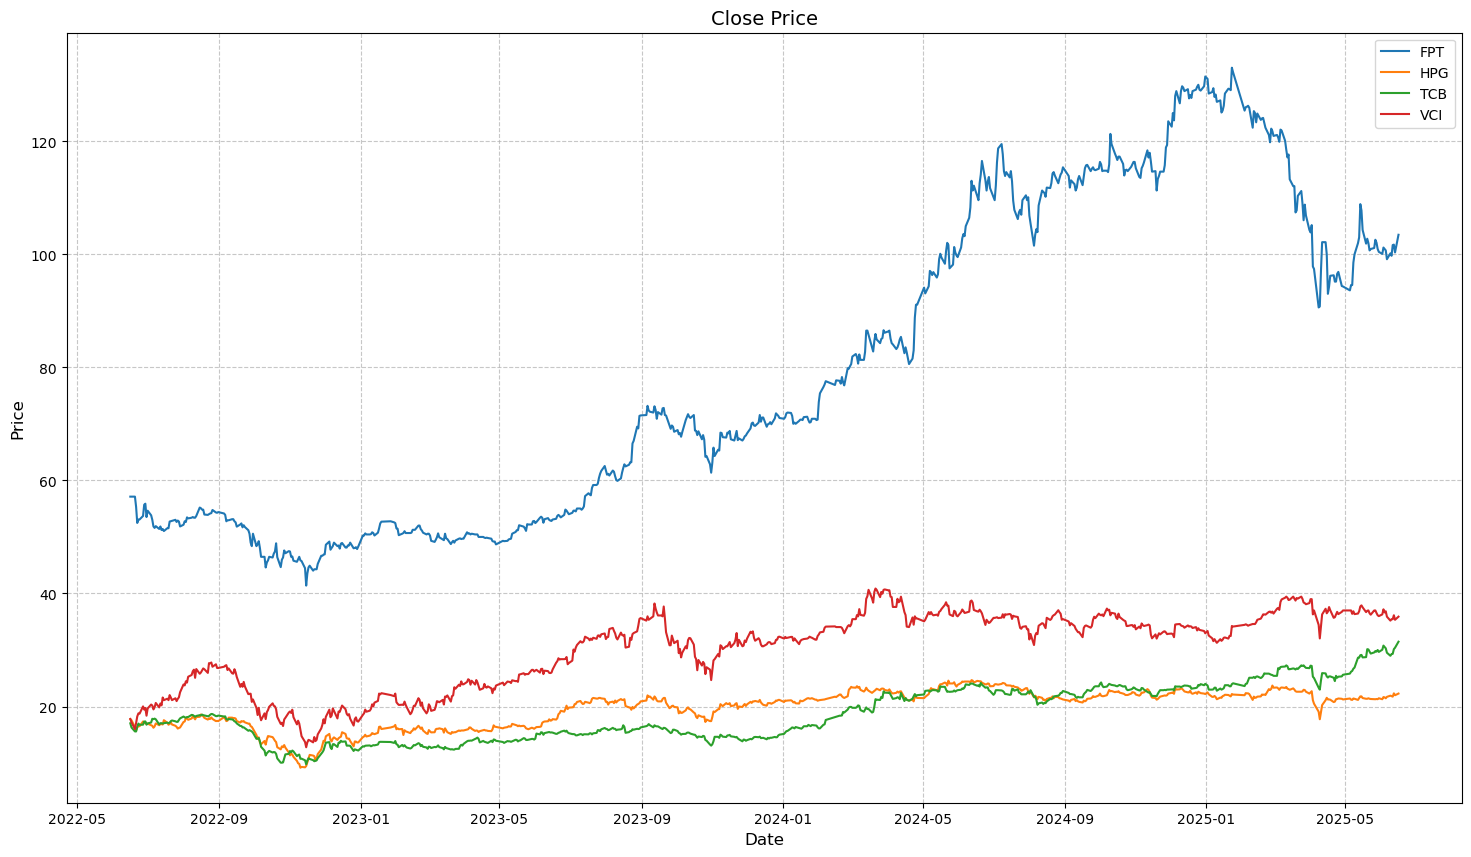

In [8]:
plt.figure(figsize=(18,10))
# Vẽ line chart cho cổ phiếu:
for col in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[col], label=col)

plt.title("Close Price", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

## Random Forest Classifier xác định buy signal

### Chuẩn bị dữ liệu 
* Tạo data frame với lợi suất của danh mục đầu tư
* Tạo các `lag features`
* Tính toán trung bình trượt (`ma5`) và độ lệch chuẩn (`vol5`) trong 5 kì
* Tạo biến `target` bằng cách shift `port_return`

In [31]:
data = pd.DataFrame({'port_return': port_returns})
for lag in [1,2,3]:
    data[f'lag_{lag}'] = data['port_return'].shift(lag)
data['ma5'] = data['port_return'].rolling(5).mean()
data['vol5'] = data['port_return'].rolling(5).std()
data.dropna(inplace=True)
data['target'] = (data['port_return'].shift(-1) > 0).astype(int)
data.dropna(inplace=True)

X = data.drop(['port_return', 'target'], axis=1)
y = data['target']

### Train mô hình
* Sử dụng kiểm định TimeSeriesSplit với `n_splits = 3`
* Lưới tham số cho RandomForestClassifier với `n_estimators` trong [10, 50] và `max_depth` trong [None, 3, 5]
* Thực hiện tìm kiếm lưới với kiểm định chéo (GridSearchCV) để tìm siêu tham số tốt nhất

In [32]:
tscv = TimeSeriesSplit(n_splits=3)
param_grid = {'n_estimators': [10, 50], 'max_depth': [None, 3, 5]}
model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='accuracy')
grid_search.fit(X, y)
best_model = grid_search.best_estimator_
print(f"best_model:  {grid_search.best_estimator_}")

best_model:  RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)


## Precision-Recall

In [33]:
# Feature importance
feature_import = best_model.feature_importances_
for feature, imp in zip(X.columns, feature_import):
    print(f"{feature}: {imp:.4f}")

lag_1: 0.1723
lag_2: 0.1904
lag_3: 0.1693
ma5: 0.2265
vol5: 0.2415


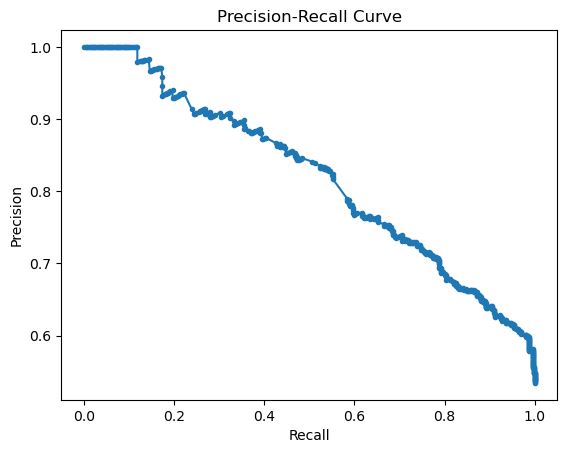

In [35]:
# Precision-Recall
probas = best_model.predict_proba(X)[:, 1]
precision, recall, thresholds = precision_recall_curve(y, probas)
# Plotting the Precision-Recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

* Ở Recall thấp (gần 0), Precision duy trì ở mức cao (gần 1), cho thấy mô hình có khả năng dự đoán chính xác tốt với các trường hợp dương tính chắc chắn.
* Khi Recall tăng (gần 0.4 trở lên), Precision giảm mạnh, đặc biệt ở Recall cao (>0.8), Precision giảm xuống dưới 0.6. Điều này cho thấy mô hình bắt đầu dự đoán nhiều trường hợp âm tính sai khi cố gắng bao phủ thêm các trường hợp dương tính.

## Value at Risk

In [13]:
def compute_portfolio_var(df_portfolio, list_stock, holding_units, confidence_level=0.95, T=1):
 

    # 1. Pivot dữ liệu thành dạng mỗi cột là một cổ phiếu
    df_pivot = df_portfolio.pivot_table(index='time', columns='symbol', values='close', aggfunc='last')
    df_pivot = df_pivot[list_stock].dropna()

    # 2. Tính log-returns
    log_returns = np.log(df_pivot / df_pivot.shift(1)).dropna()

    # 3. Tính ma trận hiệp phương sai
    cov_matrix = log_returns.cov()

    # 4. Tính tỷ trọng từng mã trong danh mục
    prices_latest = df_pivot.iloc[-1]
    values = prices_latest.values * holding_units
    portfolio_value = np.sum(values)
    weights = values / portfolio_value

    # 5. Tính phương sai và độ lệch chuẩn danh mục
    port_variance = np.dot(weights, np.dot(cov_matrix.values * T, weights.T))
    port_std_dev = np.sqrt(port_variance)

    # 6. Z-score theo mức độ tin cậy
    z_score = norm.ppf(confidence_level)

    # 7. Tính VaR (theo giá trị danh mục)
    var_pct = z_score * port_std_dev
    var_amount = portfolio_value * var_pct

    # 8. Mô phỏng giá trị danh mục trong T ngày tới (dải rủi ro)
    forecast_dates = pd.date_range(start=df_pivot.index[-1] + pd.Timedelta(days=0), periods=T)
    expected_return = log_returns.mean().dot(weights) * T
    future_mean = np.exp(expected_return)
    future_std_low = np.exp(expected_return - z_score * port_std_dev)
    future_std_high = np.exp(expected_return + z_score * port_std_dev)

    portfolio_min_value = [portfolio_value * (future_std_low ** i) for i in range(0, T)]
    portfolio_max_value = [portfolio_value * (future_std_high ** i) for i in range(0, T)]

    df_forecast = pd.DataFrame({
        'time': forecast_dates,
        'portfolio_min_value': portfolio_min_value,
        'portfolio_max_value': portfolio_max_value
    })

    return {
        'portfolio_value': portfolio_value,
        'VaR_pct': var_pct,
        'VaR_amount': var_amount,
        'confidence_level': confidence_level,
        'holding_units': holding_units,
        'weights': weights,
        'cov_matrix': cov_matrix,
        'log_returns': log_returns,
        'forecast_df': df_forecast
    }


In [14]:
def build_portfolio_value_series(df_portfolio, list_stock, holding_units):
    """
    Tạo chuỗi giá trị danh mục theo ngày.

    Args:
        df_portfolio (DataFrame): Dữ liệu có cột 'time', 'symbol', 'close'.
        list_stock (list): Danh sách mã cổ phiếu.
        holding_units (list): Số lượng nắm giữ tương ứng.

    Returns:
        DataFrame: gồm 'time' và 'portfolio_value'
    """
    df_pivot = df_portfolio.pivot_table(index='time', columns='symbol', values='close', aggfunc='last')
    df_pivot = df_pivot[list_stock].dropna()
    weights = np.array(holding_units)
    df_pivot['portfolio_value'] = (df_pivot.values * weights).sum(axis=1)
    df_pivot = df_pivot[['portfolio_value']]
    df_pivot.reset_index(inplace=True)
    return df_pivot


def forecast_portfolio_value_with_var(df_value: pd.DataFrame,
                                      list_stock: list,
                                      holding_units: list,
                                      confidence_level: float = 0.95,
                                      T: int = 5,
                                      days_back: int = 60,
                                      figsize: tuple = (12, 6),
                                      datetime_format: str = '%Y-%m-%d'):
    """
    Vẽ biểu đồ khoảng giá trị danh mục dự báo ±VaR trong T ngày tới.

    Args:
        df_value: DataFrame gồm cột 'time', 'symbol', 'close'
        list_stock: Danh sách cổ phiếu trong danh mục
        holding_units: Số lượng nắm giữ tương ứng với từng cổ phiếu
    """
    if len(list_stock) != len(holding_units):
        raise ValueError(f"Số lượng mã cổ phiếu ({len(list_stock)}) và số lượng nắm giữ ({len(holding_units)}) không khớp.")

    df_port_value = build_portfolio_value_series(df_value, list_stock, holding_units)
    df = df_port_value.copy()
    df.set_index('time', inplace=True)
    df = df.sort_index()

    # Tính log-return chuỗi danh mục
    df['log_return'] = np.log(df['portfolio_value'] / df['portfolio_value'].shift(1))
    returns = df['log_return'].dropna()
    mu = returns.mean() * T
    sigma = returns.std(ddof=1) * np.sqrt(T)
    z = norm.ppf(confidence_level)

    # Giá trị hiện tại
    S0 = df['portfolio_value'].iloc[-1]

    # Dự phóng khoảng giá trị
    future_mean = np.exp(mu)
    future_std_low = np.exp(mu - z * sigma)
    future_std_high = np.exp(mu + z * sigma)

    forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=0), periods=T)

    future_central = [S0 * future_mean**i for i in range(0, T)]
    future_lower = [S0 * future_std_low**i for i in range(0, T)]
    future_upper = [S0 * future_std_high**i for i in range(0, T)]

    # Dữ liệu quá khứ
    df_plot = df.iloc[-days_back:]

    # Vẽ biểu đồ
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(df_plot.index, df_plot['portfolio_value'], color='black', label='Portfolio Value (Past)')
    ax.plot(forecast_dates, future_central, color='blue', linestyle='--', label='Expected Future Value')
    ax.fill_between(forecast_dates, future_lower, future_upper,
                    color='orange', alpha=0.3,
                    label=f'Forecast Range ±VaR ({int(confidence_level*100)}% T={T}d)')

    ax.set_title(f"Forecast Portfolio Value with VaR ({int(confidence_level*100)}%, T={T}d)")
    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value')
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter(datetime_format))
    fig.autofmt_xdate()
    ax.legend()
    plt.tight_layout()
    plt.show()



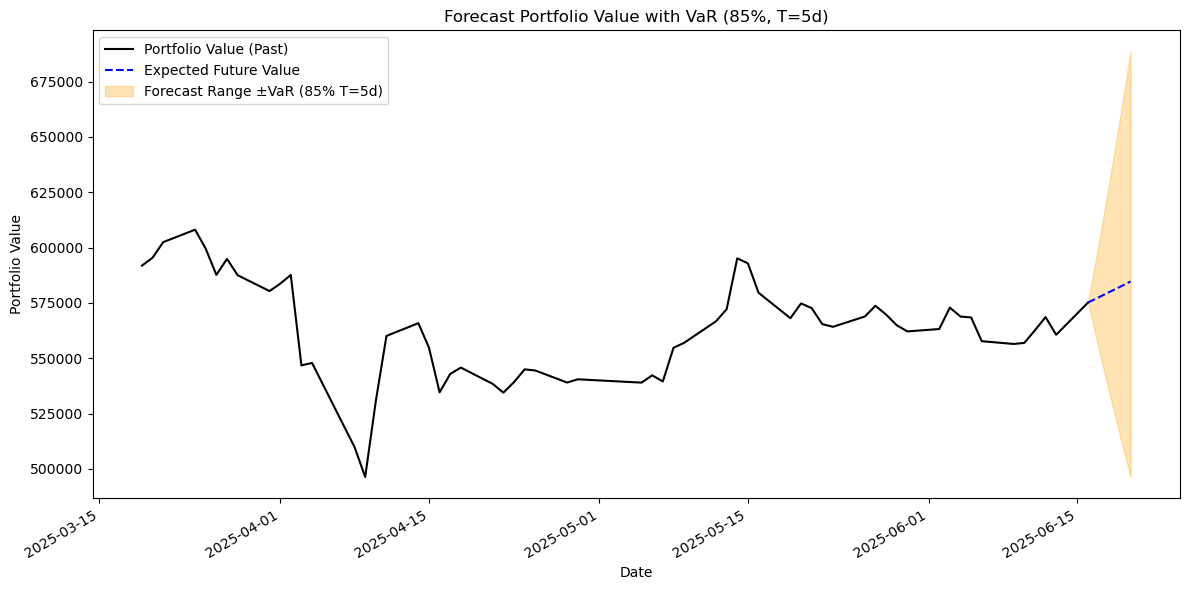

In [15]:
# 2. Vẽ khoảng dự báo với VaR
forecast_portfolio_value_with_var(df_portfolio,list_stock = tickers, holding_units = holding_units, confidence_level=0.85, T=5)

* Với 85% , biểu đồ này chấp nhận rủi ro cao hơn, phù hợp cho nhà đầu tư mạo hiểm. VaR cho T=5d nghĩa là ước lượng rủi ro trong khung thời gian ngắn (5 ngày), nhưng biểu đồ mở rộng dự báo xa hơn để minh họa tích lũy.
* Nếu kéo dài hơn 5 ngày, bất định tăng nhanh (vùng cam mở rộng), có thể dẫn đến lỗ lớn hơn (xuống dưới 500.000 vào giữa tháng 6).

-> Với VaR thấp trong 5 ngày tới, nhà đầu tư có thể giữ vị thế hiện tại nếu chấp nhận rủi ro 15%.

## Monte Carlo

In [16]:
def monte_carlo_portfolio_var(
    df_portfolio, list_stock, holding_units,
    confidence_level=0.95, T=1, n_simulations=10000
):
    """
    Tính Monte Carlo VaR cho danh mục cổ phiếu.

    Args:
        df_portfolio (pd.DataFrame): Dữ liệu gồm cột 'symbol', 'time', 'close'.
        list_stock (list): Danh sách mã cổ phiếu.
        holding_units (list): Số lượng cổ phiếu tương ứng.
        confidence_level (float): Mức độ tin cậy.
        T (int): Kỳ hạn tính VaR (ngày).
        n_simulations (int): Số lần mô phỏng.

    Returns:
        dict: Thông tin VaR và mô phỏng.
    """

    # 1. Chuẩn bị dữ liệu
    df_pivot = df_portfolio.pivot(index='time', columns='symbol', values='close')
    df_pivot = df_pivot[list_stock].dropna()

    log_returns = np.log(df_pivot / df_pivot.shift(1)).dropna()
    mu = log_returns.mean().values  # Kỳ vọng lợi suất
    cov = log_returns.cov().values  # Ma trận hiệp phương sai

    # 2. Mô phỏng log-return tương lai (giả sử phân phối chuẩn đa biến)
    mean_T = mu * T
    cov_T = cov * T  # scale theo số ngày
    sim_returns = multivariate_normal(mean_T, cov_T, size=n_simulations)  # shape: (n_sim, n_assets)

    # 3. Tính giá giả định trong tương lai
    last_prices = df_pivot.iloc[-1].values
    future_prices = np.exp(sim_returns) * last_prices  # shape: (n_sim, n_assets)

    # 4. Tính giá trị danh mục mỗi lần mô phỏng
    sim_portfolio_values = future_prices.dot(np.array(holding_units))
    current_value = last_prices.dot(np.array(holding_units))
    profit_losses = sim_portfolio_values - current_value

    # 5. Tính VaR
    var_amount = -np.percentile(profit_losses, (1 - confidence_level) * 100)

    return {
        'VaR_amount': var_amount,
        'initial_value': current_value,
        'confidence_level': confidence_level,
        'T_days': T,
        'sim_portfolio_values': sim_portfolio_values,
        'profit_losses': profit_losses,
    }


In [18]:
def forecast_portfolio_range_with_var_monte_carlo(df_portfolio: pd.DataFrame,
                                                  list_stock: list,
                                                  holding_units: list,
                                                  confidence_level: float = 0.95,
                                                  T: int = 5,
                                                  days_back: int = 60,
                                                  figsize: tuple = (12, 6),
                                                  n_simulations: int = 10000,
                                                  datetime_format: str = '%Y-%m-%d'):
    """
    Dự báo khoảng giá trị portfolio sử dụng mô phỏng Monte Carlo VaR.

    Args:
        df_portfolio: DataFrame có cột 'time', 'symbol', 'close'.
        list_stock: Danh sách mã cổ phiếu trong portfolio.
        holding_units: Số lượng cổ phiếu nắm giữ tương ứng.
    """
    # Pivot để có dạng time-series (fix lỗi duplicate index)
    df_pivot = df_portfolio.pivot_table(index='time', columns='symbol', values='close', aggfunc='last')
    df_pivot = df_pivot[list_stock].dropna()
    df_pivot.index = pd.to_datetime(df_pivot.index)
    log_returns = np.log(df_pivot / df_pivot.shift(1)).dropna()

    # Tính toán tham số mô phỏng
    mu = log_returns.mean().values
    cov = log_returns.cov().values
    mean_T = mu * T
    cov_T = cov * T
    sim_returns = multivariate_normal(mean_T, cov_T, size=n_simulations)

    # Mô phỏng giá trong T ngày tới
    last_prices = df_pivot.iloc[-1].values
    future_prices = np.exp(sim_returns) * last_prices
    sim_portfolio_values = future_prices.dot(np.array(holding_units))
    current_value = last_prices.dot(np.array(holding_units))

    # Tính log-return danh mục
    portfolio_log_returns = np.log(sim_portfolio_values / current_value)
    mu_portfolio = portfolio_log_returns.mean()
    sigma_portfolio = portfolio_log_returns.std()

    forecast_dates = pd.date_range(start=df_pivot.index[-1] + pd.Timedelta(days=0), periods=T)

    # Tính khoảng dự báo (giá trị tương lai)
    expected_returns = mu_portfolio * np.arange(T)
    std_returns = sigma_portfolio * np.sqrt(np.arange(T))
    central = current_value * np.exp(expected_returns)
    lower_bound = current_value * np.exp(expected_returns - norm.ppf(confidence_level) * std_returns)
    upper_bound = current_value * np.exp(expected_returns + norm.ppf(confidence_level) * std_returns)

    # Dữ liệu quá khứ
    portfolio_series = (df_pivot @ np.array(holding_units)).rename('portfolio_value')
    df_plot = portfolio_series.iloc[-days_back:]

    # Vẽ biểu đồ
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(df_plot.index, df_plot.values, color='black', label='Portfolio Value (Past)')
    ax.plot(forecast_dates, central, color='blue', linestyle='--', label='Expected Future Value')
    ax.fill_between(forecast_dates, lower_bound, upper_bound,
                    color='green', alpha=0.3,
                    label=f'Monte Carlo VaR ± ({int(confidence_level*100)}%, T={T}d)')

    ax.set_title(f"Forecast Portfolio Value (Monte Carlo VaR {int(confidence_level*100)}%, T={T}d)")
    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value')
    ax.xaxis.set_major_formatter(mdates.DateFormatter(datetime_format))
    fig.autofmt_xdate()
    ax.legend()
    plt.tight_layout()
    plt.show()

    # In kết quả VaR
    var_amount = -np.percentile(sim_portfolio_values - current_value, (1 - confidence_level) * 100)
    var_pct = var_amount / current_value
    print(f"✅ VaR {int(confidence_level*100)}% over {T} days: {var_amount:,.2f} VND ({-var_pct:.2%})")


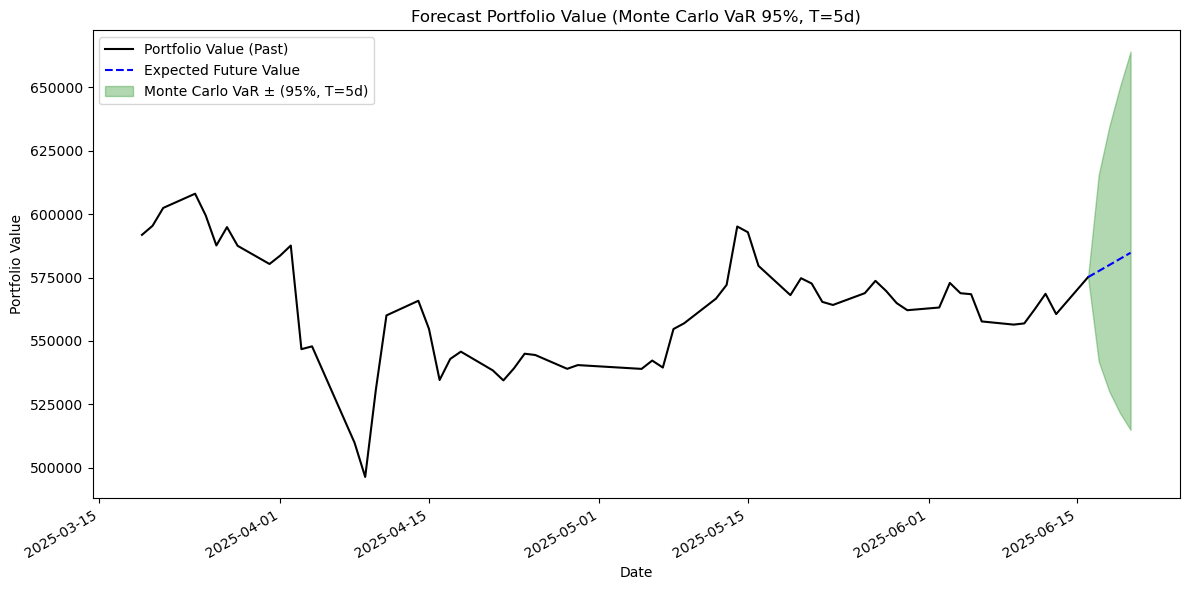

✅ VaR 95% over 5 days: 32,982.76 VND (-5.73%)


In [19]:
forecast_portfolio_range_with_var_monte_carlo(
    df_portfolio=df_portfolio,
    list_stock=tickers,
    holding_units=holding_units,
    confidence_level=0.95,
    T=5
)

* Với 95% độ tin cậy, danh mục sẽ không mất quá 5.73% (hoặc 32.982 VND) trong 5 ngày tới. Có 5% khả năng tổn thất lớn hơn.\
* Với VaR -5.73%, danh mục có rủi ro trung bình cho cổ phiếu (biến động hàng ngày ~2%). Nếu nhà đầu tư muốn giảm rủi ro, đa dạng hóa hoặc sử dụng hedging.

## CVaR

In [20]:
def forecast_portfolio_value_with_cvar(df_value: pd.DataFrame,
                                       list_stock: list,
                                       holding_units: list,
                                       confidence_level: float = 0.95,
                                       T: int = 5,
                                       days_back: int = 60,
                                       figsize: tuple = (12, 6),
                                       datetime_format: str = '%Y-%m-%d'):
    """
    Vẽ khoảng giá trị danh mục dự báo với CVaR (Expected Shortfall) trong T ngày tới.

    Args:
        df_value: DataFrame gồm cột 'time', 'symbol', 'close'
        list_stock: Danh sách mã cổ phiếu
        holding_units: Số lượng nắm giữ tương ứng
        confidence_level: Mức tin cậy (thường 0.95 hoặc 0.99)
        T: số ngày forecast
    """
    def build_portfolio_value_series(df_portfolio, list_stock, holding_units):
        df_pivot = df_portfolio.pivot_table(index='time', columns='symbol', values='close', aggfunc='last')
        df_pivot = df_pivot[list_stock].dropna()
        weights = np.array(holding_units)
        df_pivot['portfolio_value'] = (df_pivot.values * weights).sum(axis=1)
        df_pivot = df_pivot[['portfolio_value']]
        df_pivot.reset_index(inplace=True)
        return df_pivot

    if len(list_stock) != len(holding_units):
        raise ValueError("list_stock và holding_units phải có cùng độ dài.")

    df_port_value = build_portfolio_value_series(df_value, list_stock, holding_units)
    df = df_port_value.copy()
    df.set_index('time', inplace=True)
    df = df.sort_index()

    # Tính log-return
    df['log_return'] = np.log(df['portfolio_value'] / df['portfolio_value'].shift(1))
    returns = df['log_return'].dropna()

    # Ước lượng tham số
    mu = returns.mean() * T
    sigma = returns.std(ddof=1) * np.sqrt(T)
    z = norm.ppf(confidence_level)

    # Tính CVaR theo phân phối chuẩn
    alpha = 1 - confidence_level
    cvar_pct = -(mu - sigma * norm.pdf(z) / alpha)

    # Giá trị danh mục hiện tại
    S0 = df['portfolio_value'].iloc[-1]
    cvar_amount = cvar_pct * S0

    # Forecast theo hình mũ
    forecast_dates = pd.date_range(start=df.index[-1]  , periods=T+1)
    future_central = [S0 * np.exp(mu * t / T) for t in range(0, T+1)]
    future_lower = [S0 * np.exp((mu - sigma * norm.pdf(z) / alpha) * t / T) for t in range(0, T+1)]
    future_upper = [S0 * np.exp((mu + z * sigma) * t / T) for t in range(0, T+1)]

    # Biểu đồ quá khứ
    df_plot = df.iloc[-days_back:]

    # Vẽ biểu đồ
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(df_plot.index, df_plot['portfolio_value'], color='black', label='Portfolio Value (Past)')
    ax.plot(forecast_dates, future_central, color='blue', linestyle='--', label='Expected Value')
    ax.fill_between(forecast_dates, future_lower, future_upper,
                    color='red', alpha=0.3,
                    label=f'Forecast ±CVaR ({int(confidence_level*100)}%, T={T}d)')

    ax.set_title(f"Forecast Portfolio Value with CVaR ({int(confidence_level*100)}%, T={T}d)")
    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value')
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter(datetime_format))
    fig.autofmt_xdate()
    ax.legend()
    plt.tight_layout()
    plt.show()

    print(f"✅ CVaR {int(confidence_level*100)}% over {T} days: {-cvar_amount:,.2f} VND ({-cvar_pct:.2%})")


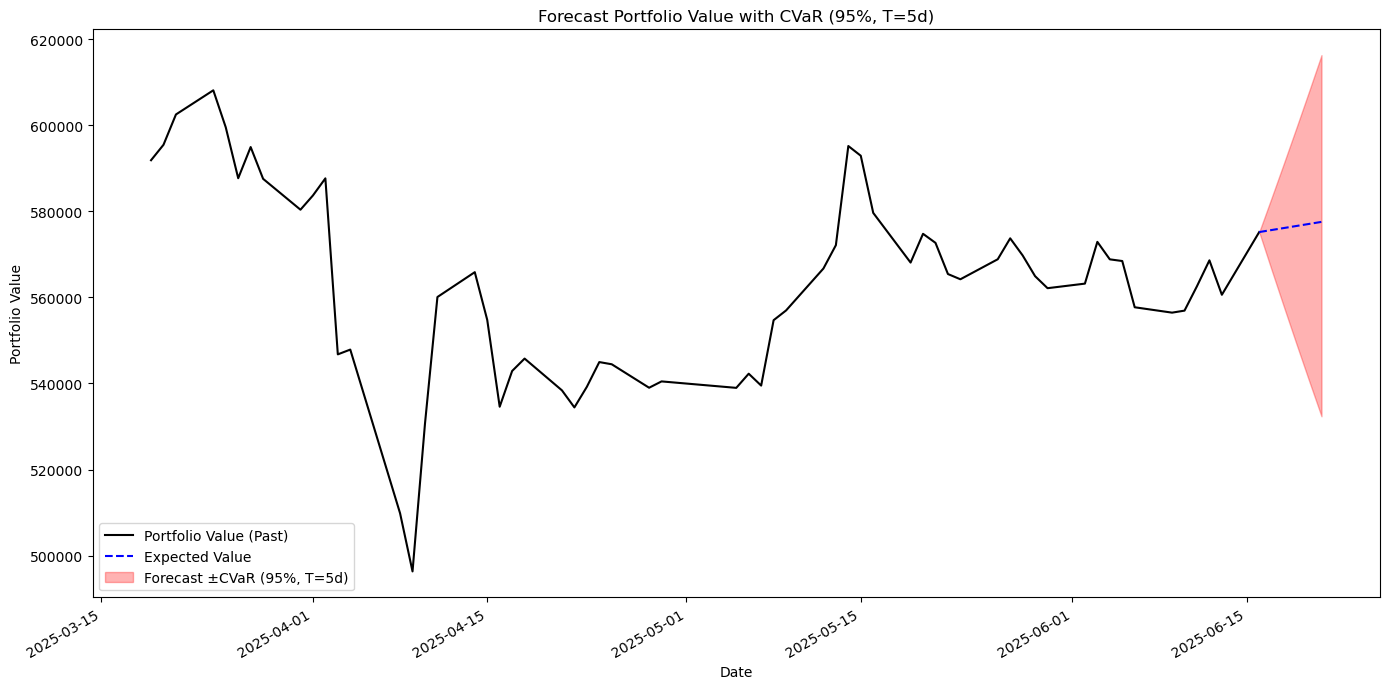

✅ CVaR 95% over 5 days: -44,464.54 VND (-7.73%)


In [21]:
forecast_portfolio_value_with_cvar(df_portfolio, list_stock=tickers, holding_units=holding_units,
                                    confidence_level=0.95, T=5, days_back=60, figsize=(14, 7))

* Với mức tin cậy 95%, trong 5 ngày tới, có 5% khả năng danh mục mất mát vượt quá VaR (Value at Risk), và mức mất mát trung bình trong những trường hợp xấu nhất đó là 7.73% (tương đương 44.464,54 VND từ giá trị hiện tại khoảng 575.000 VND).
* Chỉ số rủi ro "tail risk" (rủi ro đuôi phân bố) tốt hơn VaR vì CVaR xem xét mức độ nghiêm trọng của các mất mát cực đoan, không chỉ ngưỡng.

-> Sử dụng CVaR để đặt stop-loss hoặc hedging

## Dự báo

In [22]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

### Tính toán các chỉ số quan trọng

In [23]:
df_portfolio['SMA20'] = df_portfolio['close'].rolling(window=20).mean()
df_portfolio['SMA50'] = df_portfolio['close'].rolling(window=50).mean()

In [24]:
#Tính RSI
def calculate_rsi(df_portfolio, periods=14):
    delta = df_portfolio['close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=periods).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=periods).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df_portfolio['RSI'] = calculate_rsi(df_portfolio).fillna(0)

print(df_portfolio['RSI'])

0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
          ...    
3951    39.168279
3952    54.296161
3953    53.617811
3954    46.705588
3955    53.221083
Name: RSI, Length: 3956, dtype: float64


In [25]:
# Tạo biến mục tiêu cho bài toán phân loại (tăng = 1, giảm = 0):
df_portfolio['Price_Up'] = (df_portfolio['close'].shift(-1) > df_portfolio['close']).astype(int)

# Đặc trưng đầu vào:
features = ['open', 'high', 'low', 'volume', 'SMA20', 'SMA50', 'RSI']
X = df_portfolio[features].fillna(0)
y_regression = df_portfolio['close']  # Biến mục tiêu cho hồi quy
y_classification = df_portfolio['Price_Up']  # Biến mục tiêu cho phân loại

# Chia dữ liệu train/test (80/20):
X_train, X_test, y_train_reg, y_test_reg, y_train_clf, y_test_clf = train_test_split(
    X, y_regression, y_classification, test_size=0.2, shuffle=False
)

# Chuẩn hóa dữ liệu:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Thực hiện mô hình

In [26]:
# Linear Regression:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train_reg)
lr_pred = lr_model.predict(X_test_scaled)
lr_rmse = np.sqrt(mean_squared_error(y_test_reg, lr_pred))
lr_mae = mean_absolute_error(y_test_reg, lr_pred)
print(f'Linear Regression RMSE: {lr_rmse:.2f}')
print(f'Linear Regression MAE: {lr_mae:.2f}', "\n")

# Decision Tree Regressor:
dt_reg_model = DecisionTreeRegressor(random_state=42)
dt_reg_model.fit(X_train_scaled, y_train_reg)
dt_reg_pred = dt_reg_model.predict(X_test_scaled)
dt_reg_rmse = np.sqrt(mean_squared_error(y_test_reg, dt_reg_pred))
dt_reg_mae = mean_absolute_error(y_test_reg, dt_reg_pred)
print(f'Decision Tree Regressor RMSE: {dt_reg_rmse:.2f}')
print(f'Decision Tree Regressor MAE: {dt_reg_mae:.2f}')

# Logistic Regression:
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train_scaled, y_train_clf)
log_reg_pred = log_reg_model.predict(X_test_scaled)
log_reg_pred_proba = log_reg_model.predict_proba(X_test_scaled)[:, 1]
log_reg_cm = confusion_matrix(y_test_clf, log_reg_pred)
log_reg_auc = roc_auc_score(y_test_clf, log_reg_pred_proba)
print(f'Logistic Regression Confusion Matrix:\n{log_reg_cm}', "\n")
print(f'Logistic Regression AUC: {log_reg_auc:.2f}', "\n")

# Decision Tree Classifier:
dt_clf_model = DecisionTreeClassifier(random_state=42)
dt_clf_model.fit(X_train_scaled, y_train_clf)
dt_clf_pred = dt_clf_model.predict(X_test_scaled)
dt_clf_pred_proba = dt_clf_model.predict_proba(X_test_scaled)[:, 1]
dt_clf_cm = confusion_matrix(y_test_clf, dt_clf_pred)
dt_clf_auc = roc_auc_score(y_test_clf, dt_clf_pred_proba)
print(f'Decision Tree Classifier Confusion Matrix:\n{dt_clf_cm}', "\n")
print(f"Decision Tree Classifier - AUC: {dt_clf_auc:.2f}")

Linear Regression RMSE: 0.71
Linear Regression MAE: 0.51 

Decision Tree Regressor RMSE: 49.06
Decision Tree Regressor MAE: 42.77
Logistic Regression Confusion Matrix:
[[390   2]
 [400   0]] 

Logistic Regression AUC: 0.50 

Decision Tree Classifier Confusion Matrix:
[[352  40]
 [343  57]] 

Decision Tree Classifier - AUC: 0.52


* Linear Regression 
    * Hiệu suất khá ổn định với lỗi thấp, cho thấy mô hình dự báo gần với giá trị trung bình của dữ liệu. Nếu target ở khoảng 0-1 , 
    RMSE ≈ 0.71 tương đương với một mô hình dự báo hằng số (constant predictor, ví dụ luôn dự báo 0.5, dẫn đến RMSE ≈ √0.5 ≈ 0.707 và MAE ≈ 0.5).
    * Đánh giá: Trung bình đến kém nếu target nhị phân/liên tục nhỏ.
* Decision Tree Regression
    * Lỗi cực kỳ cao so với Linear Regression (cao gấp ~70 lần RMSE), cho thấy mô hình dự báo lệch xa thực tế. Có thể do overfit trên train set (cây sâu, không prune), dẫn đến generalize kém trên test set.

* Logistic Regression
    * Mô hình gần như luôn dự báo lớp 0 (TN=390/392 ≈ 99% đúng lớp 0, nhưng TP=0/400 = 0% đúng lớp 1). Độ chính xác tổng (accuracy) ≈ (390+0)/792 ≈ 49.2%, kém hơn random (50%).
    * AUC=0.50 xác nhận mô hình tương đương đoán ngẫu nhiên. Precision/Recall cho lớp 1 = 0 (không dự báo positives nào). Có thể do imbalance nhẹ, threshold mặc định, hoặc features không phân biệt được lớp.
* Decision Tree Classifier
    * Tốt hơn Logistic một chút, với TP=57/400 ≈ 14.25% (recall thấp), nhưng FP=40 (precision cho lớp 1 = 57/(40+57) ≈ 58.8%). Accuracy ≈ (352+57)/792 ≈ 51.6%, hơi trên 50%. AUC=0.52 cho thấy cải thiện nhẹ so với random, nhưng vẫn yếu.

### Đánh giá 

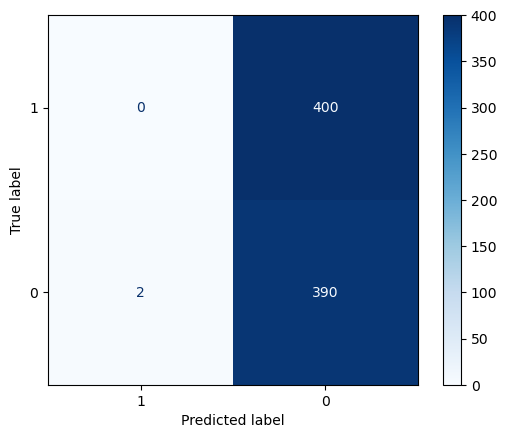

In [27]:
#Confusion matrix:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test_clf,
                                        log_reg_pred,
                                        labels = [1, 0],
                                        cmap = 'Blues' # colormap
                                       )

Mô hình chỉ giỏi dự báo lớp 1 (recall 100%), nhưng hoàn toàn thất bại với lớp 0 (recall 0.5%). Đây là trường hợp mô hình "biased predictor" (chỉ đoán một lớp), tương đương với baseline ngây thơ luôn đoán lớp 1.

In [28]:
from sklearn.metrics import classification_report, accuracy_score

print(accuracy_score(y_test_clf, log_reg_pred))
print(classification_report(y_test_clf, log_reg_pred))

0.49242424242424243
              precision    recall  f1-score   support

           0       0.49      0.99      0.66       392
           1       0.00      0.00      0.00       400

    accuracy                           0.49       792
   macro avg       0.25      0.50      0.33       792
weighted avg       0.24      0.49      0.33       792



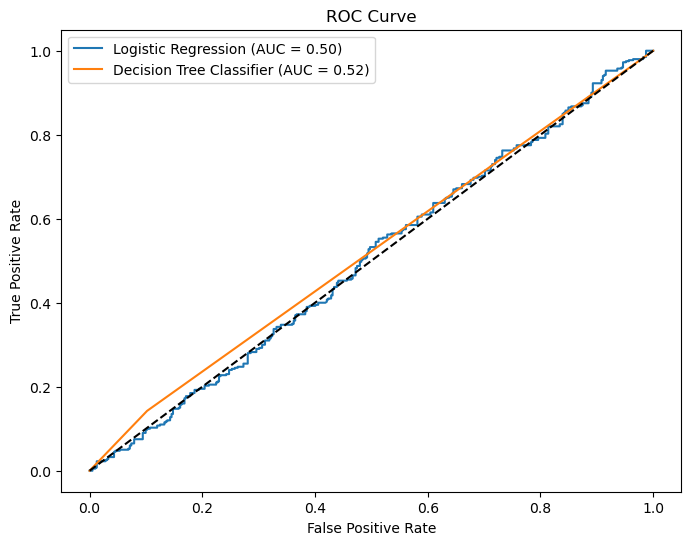

In [29]:
# Vẽ ROC Curve:
fpr_log, tpr_log, _ = roc_curve(y_test_clf, log_reg_pred_proba)
fpr_dt, tpr_dt, _ = roc_curve(y_test_clf, dt_clf_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {log_reg_auc:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree Classifier (AUC = {dt_clf_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Với AUC ~0.5, cả hai mô hình không đáng tin cậy để sử dụng trong thực tế. Một mô hình có AUC > 0.7 thường được coi là chấp nhận được, > 0.8 là tốt. Có thể ko sử dụng được dữ liệu từ VN-Index.